In [2]:
import gc
import os
import warnings
import inspect
import tqdm

from pathlib import Path

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numba
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModel

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

import bioframe as bf
import bioframe.vis
from Bio import SeqIO

import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

import sys 
sys.path.append("../")
from dnalm.downstream_tasks.promoter_prediction.dataset import EPDnewPromoterDataset
from dnalm.src.gena_lm.modeling_bert import BertForSequenceClassification

MAX_SAMPLE_TOKS = None
MAX_REF_LEN = 1
MAX_ALT_LEN = 1
EQUAL_LEN = True

In [3]:
from dataclasses import dataclass, asdict 

@dataclass 
class SeqDescription:
    chr: str
    tss: int
    strand: str
    lpos: int
    rpos: int 

    @classmethod
    def from_str(cls, s: str):
        fields = s.split(";")
        info = dict([x.split(":") for x in fields])
        self = cls(
            chr=info['chr'],
            tss=int(info['tss']),
            strand=info['strand'],
            lpos=int(info['lpos']),
            rpos=int(info['rpos'])
        )
        return self

    def to_str(self) -> str:
        info = asdict(self)
        fields = [f"{key}:{value}" for key, value in info.items()]
        s = ";".join(fields)
        return s

def parse_seq_description(s):
    fields = s.split(";")
    info = dict([x.split(":") for x in fields])
    return info 

In [4]:

@numba.jit 
def val2quantiles(a):
    indices = np.argsort(a)
    quantiles = np.zeros(a.shape, dtype=np.float32)
    
    prev_i = 0 
    sum_i = 0
    for i in range(0, indices.shape[0] - 1):
        sum_i += i + 1
        j = indices[i] 
        if a[j] != a[indices[i+1]]:
            q = sum_i / (i - prev_i + 1)
            for k in range(prev_i, i+1):
                quantiles[indices[k]] = q
            sum_i = 0
            prev_i = i + 1
    sum_i += indices.shape[0]
    q = sum_i / (indices.shape[0] - prev_i)
    for k in range(prev_i, indices.shape[0]):
        quantiles[indices[k]] = q

    quantiles = quantiles / a.shape[0] * 100 
    return quantiles 

In [5]:
DEVICE=0
PROMOTERS_PATH="human_epdnew_fH7d2.bed"
CLINVAR_PATH="clinvar_reg.tsv"
TOKENIZER_PATH="/mnt/10tb/home/penzar/dnabert_tokenizers/t2t_1000h_multi_32k/"
MODEL_CFG_PATH="/mnt/10tb/home/penzar/dnabert_configs/L24-H1024-A16-V32k-preln-lastln.json"
MODEL_WEIGHT_PATH="/mnt/10tb/home/penzar/GENALM/DIMA_promoters_2000/large/model_best.pth"

In [6]:
epdnew = pd.read_table(PROMOTERS_PATH, header=None, names=["chrom", "start", "end", "name", "length", "strand"])

In [7]:
def extend(row, lbord, rbord):
    strand = row.strand 
    start = row.start
    end = row.end
    if strand == "+":
        lpos = start-lbord
        rpos = end+rbord
    elif strand == "-":
        lpos= start - rbord
        rpos = end + lbord
    else:
        raise Exception(f"Wrong strand: {strand}")
    row.start = lpos
    row.end = rpos 
    return row 
proms = epdnew.apply(lambda x: extend(x, 1000, 999), axis=1)

In [8]:
genome = SeqIO.to_dict(SeqIO.parse("hg38.fa", format="fasta"))

In [9]:
device = torch.device(f"cuda:{DEVICE}" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
model_cfg = AutoConfig.from_pretrained(MODEL_CFG_PATH)
model = BertForSequenceClassification(model_cfg).to(device)

light_dict = torch.load(MODEL_WEIGHT_PATH, map_location="cpu")
model.load_state_dict(
    light_dict['model_state_dict'])

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=3)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (pre_attention_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (post_attention_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
clinvar_no_exons = pd.read_table('clinvar_reg.tsv')
clinvar_prom_overlap = bf.overlap(clinvar_no_exons, proms,  how="left", suffixes=("", "_prom"))
clinvar_prom_overlap = clinvar_prom_overlap[~pd.isnull(clinvar_prom_overlap.chrom_prom)]
clinvar_prom_overlap = clinvar_prom_overlap.rename({'start': 'mut_start', "end": "mut_end"}, axis=1)
autosomes = set(f'chr{i}' for i in range(1, 22+1))
clinvar_prom_overlap = clinvar_prom_overlap[clinvar_prom_overlap.chrom.isin(autosomes)]

mask = clinvar_prom_overlap['alt'].str.len() == clinvar_prom_overlap['ref'].str.len() 

mask = np.logical_and(clinvar_prom_overlap['alt'].str.len() == 1,
                      clinvar_prom_overlap['ref'].str.len() == 1)
clinvar_prom_overlap = clinvar_prom_overlap[mask]

In [11]:
prom_names = set(clinvar_prom_overlap['name_prom'])

In [12]:
promotors_required = proms[proms['name'].isin(prom_names)]

In [13]:
promotors_required.shape

(1358, 6)

In [14]:
seq_records = []

lbord, rbord = 0, 0
for _, ch, start, end, name, length, strand in promotors_required.itertuples():
    if strand == "+":
        lpos = start-lbord
        rpos = end+rbord
        sr =  genome[ch][lpos:rpos].upper()
    elif strand == "-":
        lpos= start - rbord
        rpos = end + lbord
        sr = genome[ch][lpos:rpos].upper().reverse_complement()
    else:
        raise Exception(f"Wrong strand: {strand}")
    sr.id = sr.name = name 

    desc = SeqDescription(chr=ch,
                          tss=start,
                          strand=strand,
                          lpos=lpos,
                          rpos=rpos)
    sr.description = desc.to_str()
    seq_records.append(sr)

In [15]:
with open("promoters.csv", "w") as out:
    print("sequence", "promoter_presence", file=out, sep=",")
    for sr in seq_records:
        print(str(sr.seq), 1, file=out, sep=",")

In [16]:
from torch.utils.data import DataLoader
data_path = "promoters.csv"
data_path = Path(data_path).expanduser().absolute()
test_dataset = EPDnewPromoterDataset([data_path], 
                                     tokenizer=tokenizer,
                                     x_field='sequence',
                                     label_field='promoter_presence', 
                                     max_seq_len=512,
                                     pad_to_max=True, 
                                     truncate='right')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [17]:
special_tokens = ['[PAD]', '[SEP]', '[CLS]']
samples = list(iter(test_dataloader))

tokens = []
tokens_borders = []
for sample in tqdm.tqdm(samples):
    tok_tok = tokenizer.convert_ids_to_tokens(sample['input_ids'][0].detach().tolist(), skip_special_tokens=False)
    tmp_clip = []
    for i, x in enumerate(tok_tok):
        if x == '[CLS]':
            tmp_clip.append(i+1)
        elif x == '[SEP]':
            tmp_clip.append(i)
        
    tokens_borders.append(tmp_clip)
    tokens.append(tok_tok[tmp_clip[0]:tmp_clip[1]])
for tok in tokens:
    assert sum(map(len, tok)) == 2000

100%|█████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:00<00:00, 3225.03it/s]


In [18]:
def get_all_attributions(samples, tokens, tokens_borders, model, device):
    def predict_promoter(inputs, 
                        token_type_ids=None, 
                        attention_mask=None):   
        output = model(inputs, 
                       token_type_ids=token_type_ids, 
                       attention_mask=attention_mask)
        return output.logits

    def summarize_attributions(attributions):
        attributions = attributions.sum(dim=-1).squeeze(0)
        attributions = attributions / torch.norm(attributions)
        return attributions
    
    lig_object = LayerIntegratedGradients(predict_promoter, model.bert.embeddings)    
    
    all_attr = []
    for model_input, tokens, boards in tqdm.tqdm(zip(samples, tokens, tokens_borders), total=len(samples)):
        for k in model_input:
            model_input[k] = model_input[k].to(device)
        
        attributions = lig_object.attribute(model_input['input_ids'], target=0, n_steps=10, return_convergence_delta=False)
        attributions = attributions[:, boards[0]:boards[1], :]
        attributions_sum = summarize_attributions(attributions)
        all_attr.append(attributions_sum.cpu())
        
    # clear Memory
    gc.collect()
    torch.cuda.empty_cache() # PyTorch thing
    
    return all_attr

In [19]:
attr = get_all_attributions(samples, tokens, tokens_borders, model, device)

100%|███████████████████████████████████████████████████████████████████████████████| 1358/1358 [16:49<00:00,  1.35it/s]


In [20]:
res = { 'sample_ind': [], 'tok_pos': [], 'token': [], 'attr': []}

#for i in range(len(samples)):
for i in range(len(samples)):
    attributions = attr[i].tolist()
    for pos, j in enumerate(range(len(tokens[i]))):
        res['tok_pos'].append(pos)
        res['attr'].append(attributions[j])
        res['token'].append(tokens[i][j])
        res['sample_ind'].append(i)

res_df = pd.DataFrame.from_dict(res)

In [21]:
cur_pos = None
cur_sample_ind = -1 

starts, ends, chroms, strands = [], [], [], []
for _, sample_ind, tok_pos, token, attr in res_df.itertuples():
    if sample_ind != cur_sample_ind:
        cur_sample_ind = sample_ind
        seqrec = seq_records[sample_ind]
        seqinfo = SeqDescription.from_str(seqrec.description)
        strand = seqinfo.strand
        chrom = seqinfo.chr
        if strand == "+":
            cur_pos = int(seqinfo.lpos)
        else:
            cur_pos = int(seqinfo.rpos) 
    if strand == "+":
        s, e = cur_pos, cur_pos + len(token)
        cur_pos = e
    elif strand == "-":
        s, e =  cur_pos - len(token), cur_pos
        cur_pos = s 
    else:
        raise Exception(f"Wrong strand: {strand}")
    starts.append(s)
    ends.append(e)
    chroms.append(chrom)
    strands.append(strand)

In [22]:
res_df["start"] = starts
res_df["end"] = ends
res_df["chrom"] = chroms
res_df["strand"] = strands

In [23]:
res_df.head()

,sample_ind,tok_pos,token,attr,start,end,chrom,strand
0,0,0,TTGGAGAA,0.010833,1012496,1012504,chr1,+
1,0,1,ATGTC,0.025104,1012504,1012509,chr1,+
2,0,2,TATTGAAG,0.008712,1012509,1012517,chr1,+
3,0,3,TCTTTT,0.014143,1012517,1012523,chr1,+
4,0,4,GGCC,0.028929,1012523,1012527,chr1,+


In [24]:
res_df.to_csv("attributions_large_model.tsv", sep="\t", index=None)

In [25]:
attr_table = res_df[['chrom', 'start', 'end', 'strand', 'token', 'tok_pos', 'attr', 'sample_ind']].copy()

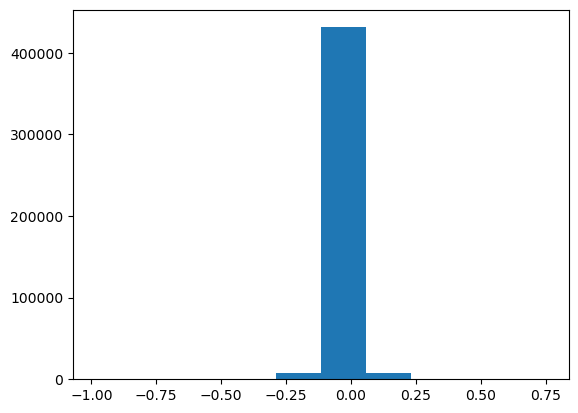

In [26]:
plt.hist(attr_table['attr'])
plt.show()

In [27]:
attr_table['q_attr'] = attr_table[['sample_ind', 'attr']].groupby('sample_ind')['attr'].transform(lambda x: val2quantiles(np.abs(x.values)))

In [28]:
Q_TH = 99
MAX_REF_LEN = 1
MAX_ALT_LEN= 1
MAX_SAMPLE_TOKS = 1

mask = np.logical_and(clinvar_no_exons['ref'].str.len() == 1,
                     clinvar_no_exons['alt'].str.len() ==1)
clinvar_no_exons = clinvar_no_exons[mask]

# take tokens ovarlapping with clinvar variants 
signif_clinvar_overlap = bf.overlap(attr_table, clinvar_no_exons, how="left", suffixes=("", "_clinvar"))
signif_clinvar_overlap = signif_clinvar_overlap[~pd.isnull(signif_clinvar_overlap['start_clinvar'])] 
print("CLINVAR",  len(set(signif_clinvar_overlap['clinvar_id_clinvar'])))

# keep autosomes only 
autosomes = set(f'chr{i}' for i in range(1, 22+1))
signif_clinvar_overlap = signif_clinvar_overlap[signif_clinvar_overlap.chrom.isin(autosomes)]

# if clinvar variant overlaps with multiple tokens from the same sample
# predict significant mutation if any of tokens is significant
def remove_token_uncertainty_max(df, q_th=99):
    num_tokens = len(df)
    r = df.iloc[0].copy()
    sample_ind = r.sample_ind   
    
    new_q_attr = np.max(df['q_attr'].values)
    significance = new_q_attr >= q_th
    df = pd.DataFrame([r])
    df['q_attr'] = new_q_attr
    df['significant'] = significance
    df['num_tokens'] = num_tokens
    return df

signif_clinvar_un = signif_clinvar_overlap.groupby(['clinvar_id_clinvar',
                                                    'sample_ind']).apply(lambda x: remove_token_uncertainty_max(x, q_th=Q_TH))

print(signif_clinvar_un.shape)
if MAX_SAMPLE_TOKS is not None:
    signif_clinvar_un = signif_clinvar_un[signif_clinvar_un['num_tokens'] <= MAX_SAMPLE_TOKS]
    print(signif_clinvar_un.shape)
signif_clinvar_un.reset_index(drop=True, inplace=True)

# if a clinvar variant overlaps with multiple tokens from different samples (as promoters can overlap)
# predict significant mutation is any of tokens is significant
def remove_sample_uncertainty(df): 
    if df.shape[0] == 1:
        return df 
    else:
        new_q_attr = np.max(df['q_attr'].values)
        r = df.iloc[0].copy()
        r.significant = np.any(df.significant)
        r.q_attr = new_q_attr
        return pd.DataFrame([r])

signif_clinvar_un = signif_clinvar_un.groupby(
    ['clinvar_id_clinvar']).apply(remove_sample_uncertainty)
print(signif_clinvar_un.shape)
signif_clinvar_un.reset_index(drop=True, inplace=True)

CLINVAR 2012
(2783, 22)
(2783, 22)
(2012, 22)


In [234]:
tb = pd.crosstab(signif_clinvar_un['significant'], signif_clinvar_un['significance_clinvar'])
print(tb)
print(chi2_contingency(tb))
tb.loc[False,'pathogenic'] / tb.loc[False, :].sum(), tb.loc[True,'pathogenic'] / tb.loc[True, :].sum()

significance_clinvar  benign  pathogenic
significant                             
False                   1184         485
True                     164         179
Chi2ContingencyResult(statistic=67.78665025835488, pvalue=1.8217878605944651e-16, dof=1, expected_freq=array([[1118.19681909,  550.80318091],
       [ 229.80318091,  113.19681909]]))


(0.29059316956261233, 0.521865889212828)

In [231]:
tb = pd.crosstab(signif_clinvar_un['significant'], signif_clinvar_un['significance_clinvar'])
print(tb)
print(chi2_contingency(tb))
tb.loc[False,'pathogenic'] / tb.loc[False, :].sum(), tb.loc[True,'pathogenic'] / tb.loc[True, :].sum()

significance_clinvar  benign  pathogenic
significant                             
False                   1184         485
True                     164         179
Chi2ContingencyResult(statistic=67.78665025835488, pvalue=1.8217878605944651e-16, dof=1, expected_freq=array([[1118.19681909,  550.80318091],
       [ 229.80318091,  113.19681909]]))


(0.29059316956261233, 0.521865889212828)

In [241]:
y_pred = signif_clinvar_un['q_attr']
y_true = signif_clinvar_un['significance_clinvar'] == "pathogenic"

In [251]:
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

In [243]:
roc_auc_score(y_score=y_pred, y_true=y_true)

0.5275692905151764

In [246]:
average_precision_score(y_score=y_pred, y_true=y_true)

0.42189360821123206

In [247]:
y_true.mean()

0.33001988071570576

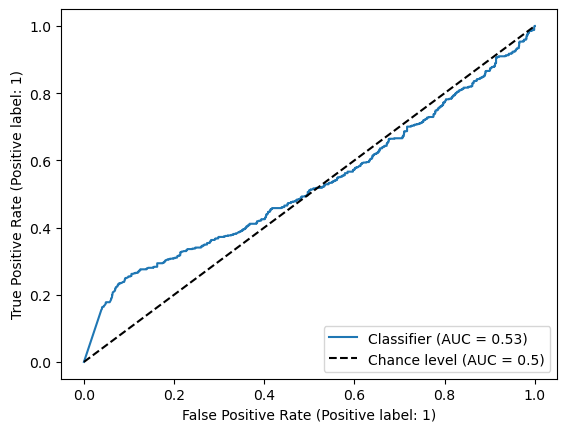

In [250]:
RocCurveDisplay.from_predictions(y_pred=y_pred, y_true=y_true, plot_chance_level=True)

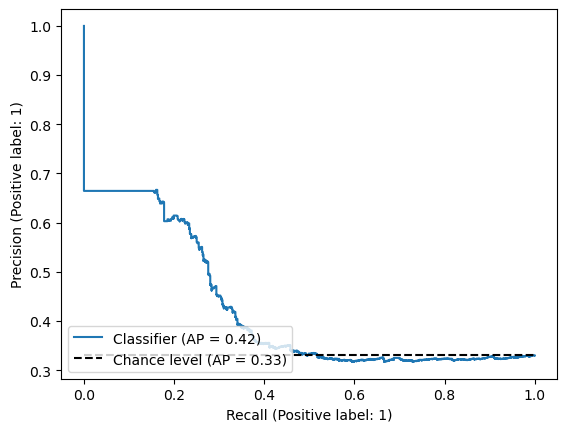

In [252]:
PrecisionRecallDisplay.from_predictions(y_pred=y_pred, y_true=y_true, plot_chance_level=True)